In [220]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [221]:
#read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]  # print first 8 words

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [222]:
len(words)  # how many words?


32033

In [223]:
# build vocabulary of all unique characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}  # string to integer
stoi['.'] = 0  # add a special end-of-word token
itos = {i:s for s, i in stoi.items()}  # integer to string
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset

block_size = 3  # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    #print(f'word: {w}')
    context = [0] * block_size  # start with a context of all zeros
    for ch in w + '.':  # add the end-of-word token
        ix = stoi[ch]  # convert character to integer
        X.append(context)  # append the context
        Y.append(ix)  # append the target character
        #print(f'  context: {context}, target: {ix} ({itos[ix]})')
        context = context[1:] + [ix]  # slide the window: remove the first character and add the new one
X = torch.tensor(X) #  Tensor of shape (N, block_size) containing the context
Y = torch.tensor(Y) # Tensor of shape (N,) containing the targets

In [ ]:
(X.shape, Y.shape, X.dtype, Y.dtype, X[0], Y[0], itos[Y[0].item()])  # check the shapes and types of the tensors

In [ ]:
# neural network model to take Xs and predict Ys with lookup table C
C = torch.randn((27, 2), dtype=torch.float32, requires_grad=True)


In [ ]:
emb = C[X]
print(emb.shape)

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

h = emb.view(-1,6) @ W1 + b1  # this is a linear layer that takes the embeddings and produces a hidden state to concatenate the embeddings and pass through a linear layer, we can use torch.cat, torch.unbind, or torch.view

In [ ]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [ ]:
h

In [ ]:
print(h.shape)  # should be (N, 100) - 100 activation values for each example in the batch, here 32 examples


(emb.view(-1,6) @ W1).shape

b1.shape    

broadcasting :
# 32 , 100 ---> 32 , 100
#     100  --->  1 , 100
we need to add the bias to each row of h
h = h + b1  # add the bias to each row of h

In [ ]:
W2 = torch.randn((100, 27)) # output layer weights, for 100 inputs, 27 because there are 27 possible outut characters
b2 = torch.randn(27) # output layer biases

In [ ]:
logits = h @ W2 + b2  # logits: unnormalized log probabilities for each character

In [ ]:
logits.shape  # should be (N, 27) - 27 logits for each example in the batch

In [ ]:
counts = logits.exp()  # convert logits to counts (unnormalized probabilities)
probs = counts / counts.sum(1, keepdim=True)  # normalize to get probabilities
print(probs.shape)  # should be (N, 27) - 27 probabilities for each example in the batch

We need to index into rows of probs, and from each row we need to pluck out the prob corresponding to that correct character in Y

output Y is a tensor of shape (N,) containing the target characters

In [ ]:
probs[torch.arange(32), Y]  # get the probabilities of the correct characters (rows, columns indexed by Y)

In [ ]:
loss  = -probs[torch.arange(32), Y].log().mean()  # negative log likelihood loss
loss

#  Rewrote the the code above in a more structured way 

In [ ]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((27, 2), dtype=torch.float32, requires_grad=True, generator=g)  # character embedding matrix
W1 = torch.randn((6, 100), generator=g)  # first layer weights
b1 = torch.randn(100, generator=g)  # first layer biases
W2 = torch.randn((100, 27), generator=g)  # output layer weights
b2 = torch.randn(27, generator=g)  # output layer biases
parameters = [C, W1, b1, W2, b2]  # list of all parameters

In [ ]:
sum(p.nelement() for p in parameters)  # total number of parameters in the model


In [ ]:
for p in parameters:
    p.requires_grad = True  # make sure all parameters require gradients

`F.cross_entropy` is a PyTorch function that combines **log softmax** and **negative log-likelihood loss** into a single operation. It is commonly used for multi-class classification problems. Here's why it is preferred:

1. **Numerical Stability**: 
    - `F.cross_entropy` internally applies the log softmax operation to the logits (raw scores) before computing the negative log-likelihood loss. This avoids numerical instability that can arise when computing probabilities and their logarithms separately.

2. **Efficiency**:
    - By combining the two operations (log softmax and NLL loss), `F.cross_entropy` is computationally more efficient than performing them separately.

3. **Simplified Workflow**:
    - It directly takes the raw logits (unnormalized scores) as input and computes the loss, so you don't need to manually normalize the logits into probabilities.

4. **Handles Multi-Class Problems**:
    - It is specifically designed for multi-class classification, where each example belongs to one of several classes.

5. **Effects on Forward and Backward Passes**:
    - **Forward Pass**: `F.cross_entropy` computes the loss in a single step, reducing the computational overhead compared to performing log softmax and NLL loss separately.
    - **Backward Pass**: The combined operation ensures that gradients are computed efficiently and correctly propagated through the network, avoiding potential issues with separate gradient calculations for log softmax and NLL loss.

In your case, `F.cross_entropy(logits, Y)` is used because:
- `logits` are the raw scores output by the model.
- `Y` contains the target class indices for each example.
- `F.cross_entropy` computes the loss by comparing the predicted probabilities (via log softmax) with the true class labels in `Y`.

In [ ]:
lre = torch.linspace(0.-3, 0, 1000)  
lrs = 10**lre  # learning rates from 0.001 to 1.0

# Mini batches construct
torch.randint(0, X.shape[0], (32,))  
 random indices for a batch of size 32
 this will give you a tensor of random indices to sample from X and Y for training.

It's much better to have an approximate gradient and just make more steps than it is to evaluate the exact gradient and take fewer steps

In [ ]:
lri = []
lossi = []
for _ in range(10000):  # training loop

    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))  # random indices for a batch of size 32

    # forward pass through the model
    emb = C[X[ix]]  # get the embeddings for the context
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # first layer: linear transformation + tanh activation
    logits = h @ W2 + b2  # output layer: linear transformation to logits
    loss = F.cross_entropy(logits, Y[ix])  # equivalent to the loss we computed manually - refer above notes
    #print(f'loss: {loss.item()}')  # print the loss for this iteration

    #backward pass to compute gradients
    for p in parameters:
        p.grad = None  # zero the gradients
    loss.backward()  # compute gradients

    # update the parameters
    #lr = lrs[_]  # learning rate for this iteration
    lr = 0.01  # fixed learning rate using track status first 0.1 for few iterations, then 0.01(learning rate decay)
    for p in parameters:
        p.data += -lr * p.grad

    ##track stats - this gives the exponent to be used for the learning rate as -1 => 0.1
    #lri.append(lre[_])
    #lossi.append(loss.item()) 

print('final loss:', loss.item())

In [ ]:
emb = C[X[ix]]  # get the embeddings for the context
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # first layer: linear transformation + tanh activation
logits = h @ W2 + b2  # output layer: linear transformation to logits
loss = F.cross_entropy(logits, Y[ix])
loss

# training split, dev/validation split, test split
80% training, 10% validation, 10% test 

80% of teh data used to optimize the parameters of the model using gradient descent

10% of the data used to validate the model during training over all the hyperparameters to find the best model(ex. strength of regularization), to check if the model is overfitting

10% of the data used to test the model after training is complete, to see how well it generalizes to unseen data



In [224]:
# build the dataset

def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        #print(f'word: {w}')
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(f'  context: {context}, target: {ix} ({itos[ix]})')
            context = context[1:] + [ix]  # slide the window: remove the first character and add the new one
    X = torch.tensor(X)  # Tensor of shape (N, block_size) containing the context
    Y = torch.tensor(Y)  # Tensor of shape (N,) containing the targets
    print(f'X shape: {X.shape}, Y shape: {Y.shape}') 
    return X, Y

import random
random.seed(42)  # for reproducibility
random.shuffle(words)  # shuffle the words to get a random dataset
n1 = int(0.8 * len(words))  # 80% for training
n2 = int(0.9 * len(words))  # 10% for validation

block_size = 3 # context length: how many characters do we take to predict the next one?
Xtrain, Ytrain = build_dataset(words[:n1], block_size)  # training set
Xdev, Ydev = build_dataset(words[n1:n2], block_size)  # validation set
Xtest, Ytest = build_dataset(words[n2:], block_size)  # test set

X shape: torch.Size([182625, 3]), Y shape: torch.Size([182625])
X shape: torch.Size([22655, 3]), Y shape: torch.Size([22655])
X shape: torch.Size([22866, 3]), Y shape: torch.Size([22866])


# Copied from above

In [225]:
Xtrain.shape, Ytrain.shape, Xdev.shape, Ydev.shape, Xtest.shape, Ytest.shape  # check the shapes of the datasets

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [276]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((27, 10), dtype=torch.float32, requires_grad=True, generator=g)  # character embedding matrix
W1 = torch.randn((30, 200), generator=g)  # first layer weights 30 = 3 * block_size(from research paper link below)
b1 = torch.randn(200, generator=g)  # first layer biases
W2 = torch.randn((200, 27), generator=g)  # output layer weights
b2 = torch.randn(27, generator=g)  # output layer biases
parameters = [C, W1, b1, W2, b2]  # list of all parameters

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [277]:
sum(p.nelement() for p in parameters)  # total number of parameters in the model

11897

In [278]:
for p in parameters:
    p.requires_grad = True  

In [279]:
lre = torch.linspace(0.-3, 0, 1000)  
lrs = 10**lre  # learning rates from 0.001 to 1.0

In [280]:
lri = []
lossi = []
stepsi = []

# Possible parameter changes we can do to optimize as the context
- How long are we running (no. of optimizations)
- what is the learning rate and how does it change over time and how does it decay
- batch size and may achieve much better convergence speed (how many seconds or minutes it takes to train the model)
- the look up table dimension
- dimension of tanh



In [297]:

for _ in range(200000):  

    # mini batch construct
    ix = torch.randint(0, Xtrain.shape[0], (32,)) 

    # forward pass through the model
    emb = C[Xtrain[ix]]  
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrain[ix]) 

    #backward pass to compute gradients
    for p in parameters:
        p.grad = None  
    loss.backward() 

    # update the parameters
    
    lr = 0.1 if _< 100000 else 0.01  # fixed learning rate using track status first 0.1 for first 100000 iterations, then 0.01(learning rate decay) 
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    #lri.append(lre[_])
    stepsi.append(_)
    lossi.append(loss.log10().item())

print('final loss:', loss.item())

final loss: 2.27972674369812


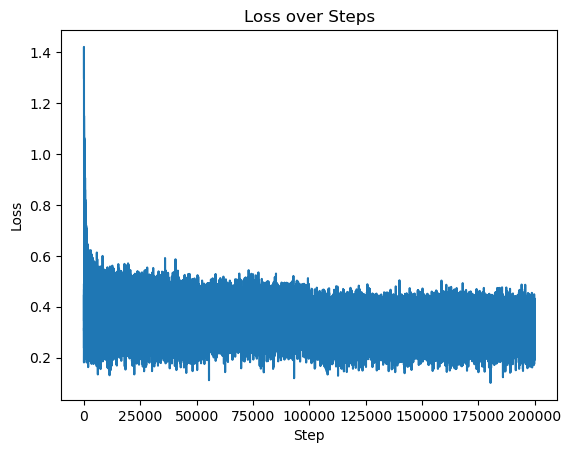

In [298]:
plt.plot(stepsi, lossi)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Steps')
plt.show()

In [299]:
emb = C[Xtrain]  
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2  
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(2.1132, grad_fn=<NllLossBackward0>)

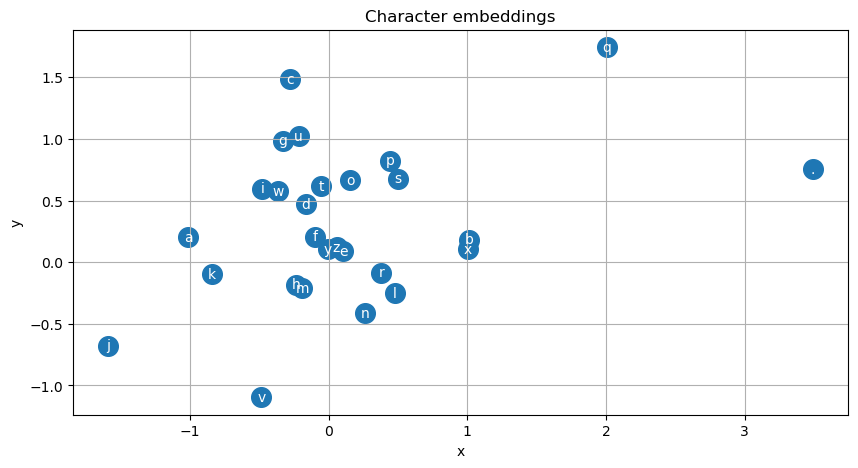

In [300]:
plt.figure(figsize=(10, 5))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color = 'white')
plt.xlabel('x')
plt.ylabel('y')
plt.grid('minor')
plt.title('Character embeddings')
plt.show()

In [301]:
emb = C[Xdev]  
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2  
loss = F.cross_entropy(logits, Ydev)  # test set
loss

tensor(2.1587, grad_fn=<NllLossBackward0>)

In [303]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)  # for reproducibility

for _ in range(20):  # generate 20 samples
    out = []
    context = [0] * block_size  # start with a context of all ... (zeros)
    while True:
        emb = C[torch.tensor([context])]  # get the embeddings for the context using table C (1, block_size, dimension)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)  # first layer: linear transformation + tanh activation
        logits = h @ W2 + b2  # output layer: linear transformation to logits
        probs = F.softmax(logits, dim=1)  # convert logits to probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()  # sample from the probabilities
        if ix == 0: break  # end of word token
        out.append(itos[ix])  # append the character to the output
        context = context[1:] + [ix]  # slide the window: remove the first character and add the new one
    print(''.join(out))  # print the generated word

mora
mayah
see
mad
ryah
rethrus
jarlee
adered
eliah
miloparekelson
anar
kateivynne
miysadbergiairiel
kin
reth
konnie
caylyn
avder
yarue
eli
